In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import dimod
import networkx as nx
from dwave.system import EmbeddingComposite, DWaveSampler, LeapHybridSampler
from collections import defaultdict
from sklearn.cluster import KMeans

In [3]:
data = pd.read_csv("iris.csv")
data.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# Preparing dataset
Removing Iris-versicolor class and taking last two columns (petal length and petal width) for better 2D visualization

     sepal length  sepal width  petal length  petal width           class
123           6.3          2.7           4.9          1.8  Iris-virginica
41            4.5          2.3           1.3          0.3     Iris-setosa
134           6.1          2.6           5.6          1.4  Iris-virginica
28            5.2          3.4           1.4          0.2     Iris-setosa
103           6.3          2.9           5.6          1.8  Iris-virginica

 Iris-virginica    50
Iris-setosa       50
Name: class, dtype: int64


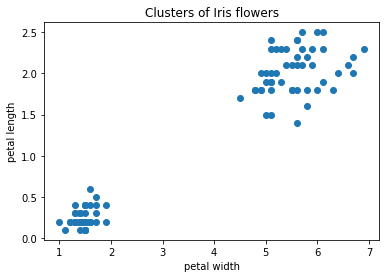

In [4]:
data1 = shuffle(data[data["class"]!='Iris-versicolor'])    # Removing Iris-versicolor for binary clustering
print(data1.head())
print("\n",data1['class'].value_counts())


plt.scatter(data1['petal length'],data1['petal width'])
plt.title('Clusters of Iris flowers')
plt.xlabel('petal width')
plt.ylabel('petal length')
plt.show()

In [5]:
X = data1.iloc[:,2:4].values  # 2D features subset

# Applying Kmeans clustering with 2 clusters

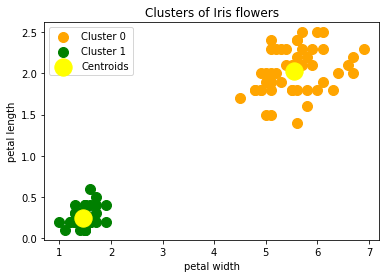

In [6]:
kmeans = KMeans(n_clusters=2, init = 'k-means++', max_iter=300, n_init=10,random_state=0)
y_kmeans = kmeans.fit_predict(X)

plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'orange', label = 'Cluster 0')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'green', label = 'Cluster 1')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of Iris flowers')
plt.xlabel('petal width')
plt.ylabel('petal length')
plt.legend()
plt.show()

# Creating Gram matrix

In [7]:
n = data1.shape[0]
D = np.zeros((n,n))
for i in range(n):
    x0, y0 = X[i,0],X[i,1]
    for j in range(n):
        D[i,j] = (x0*X[j,0]) + (y0*X[j,1])    #Gram matrix np.sqrt((x0 - X[j,0])**2 + (y0 - X[j,1])**2)


# Creating graph of binary clustering problem

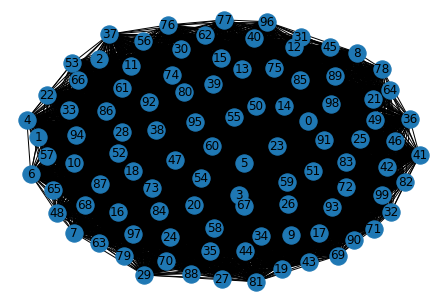

In [8]:
# Initialize a complete graph
G = nx.complete_graph(n)   
# Initialize our Q matrix
Q = defaultdict(int)

# Update Q matrix for every edge in the graph
for i, j in G.edges:            # Weighted Max-cut problem
    Q[(i,i)]+= -1*D[i,i]
    Q[(j,j)]+= -1*D[j,j]
    Q[(i,j)]+= 2*D[i,j]


bqm_qubo = dimod.BinaryQuadraticModel.from_qubo(dict(Q))
H = bqm_qubo.to_networkx_graph()
nx.draw(H,with_labels=True)

# Applying hybrid solver

In [9]:
sampleset = LeapHybridSampler().sample(bqm_qubo)
y_q = np.array(sampleset.record[0][0])
print(y_q)

[0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 1 1 1
 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 0
 1 1 0 0 0 1 0 1 1 1 0 0 0 1 1 0 1 0 1 1 1 0 1 1 0 0]


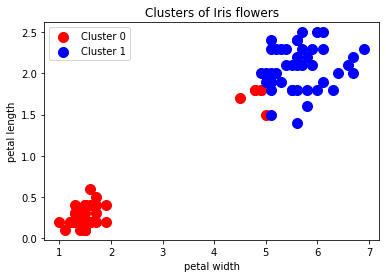

In [10]:
plt.scatter(X[y_q == 0, 0], X[y_q == 0, 1], s = 100, c = 'red', label = 'Cluster 0')
plt.scatter(X[y_q == 1, 0], X[y_q == 1, 1], s = 100, c = 'blue', label = 'Cluster 1')
plt.title('Clusters of Iris flowers')
plt.xlabel('petal width')
plt.ylabel('petal length')
plt.legend()
plt.show()
